In [1]:
import pathlib

import pandas as pd
import numpy as np
import seaborn as sns

sns.set_theme()

DEFAULT_COLORS = sns.color_palette()

import data_wrangler as dw

FIGURE_PATH = pathlib.Path('../report/figures/out/')
MODEL_PATH = pathlib.Path('./models/')

POSITIONS = ['QB', 'RB', 'WR', 'TE', 'K', 'DST']
position_colors = {
    'QB': DEFAULT_COLORS[0],
    'RB': DEFAULT_COLORS[1],
    'WR': DEFAULT_COLORS[2],
    'TE': DEFAULT_COLORS[3],
    'K': DEFAULT_COLORS[4],
    'DST': DEFAULT_COLORS[5],
}

stack_types = []
for i in range(0, 6):
    for j in range(i, 6):
        stack_types.append(POSITIONS[i] + '-' + POSITIONS[j])

def get_data():
    data = dw.get_filtered_projection_data(include_team=True)
    data = data[data['position'].isin(POSITIONS)]
    data['home_or_away'] = (data['home_or_away'] == 'HOME')
    data['home_team'] = 'NULL'
    data.loc[data['home_or_away'], 'home_team'] = data.loc[data['home_or_away'], 'team']
    data.loc[~data['home_or_away'], 'home_team'] = data.loc[~data['home_or_away'], 'opp_team']

    data = data[data['projection'] >= 1.0].copy()
    return data.rename(columns={'home_or_away': 'is_home'})

data = get_data()
print(len(data))
print(data.columns)

data['residual'] = -(data['projection'] - data['points_scored']) 
display(data)




6368
Index(['season', 'week', 'player_name', 'position', 'projection', 'team',
       'opp_team', 'is_home', 'points_scored', 'home_team'],
      dtype='object')


,season,week,player_name,position,projection,team,opp_team,is_home,points_scored,home_team,residual
0,2024,1,Josh Allen,QB,23.49,BUF,ARI,True,32.18,BUF,8.69
1,2024,1,Jalen Hurts,QB,22.55,PHI,GB,True,19.42,PHI,-3.13
2,2024,1,Lamar Jackson,QB,20.50,BAL,KC,False,29.12,KC,8.62
3,2024,1,C.J. Stroud,QB,20.35,HOU,IND,False,18.66,IND,-1.69
4,2024,1,Patrick Mahomes,QB,20.25,KC,BAL,True,16.14,KC,-4.11
...,...,...,...,...,...,...,...,...,...,...,...
27,2024,18,PIT,DST,6.30,PIT,CIN,True,9.00,PIT,2.70
28,2024,18,NO,DST,3.80,NO,TB,False,3.00,TB,-0.80
29,2024,18,TB,DST,8.80,TB,NO,True,3.00,TB,-5.80
30,2024,18,HOU,DST,7.70,HOU,TEN,False,11.00,TEN,3.30


0.7664526484751205 -0.6799999999999997
1.4464526484751201


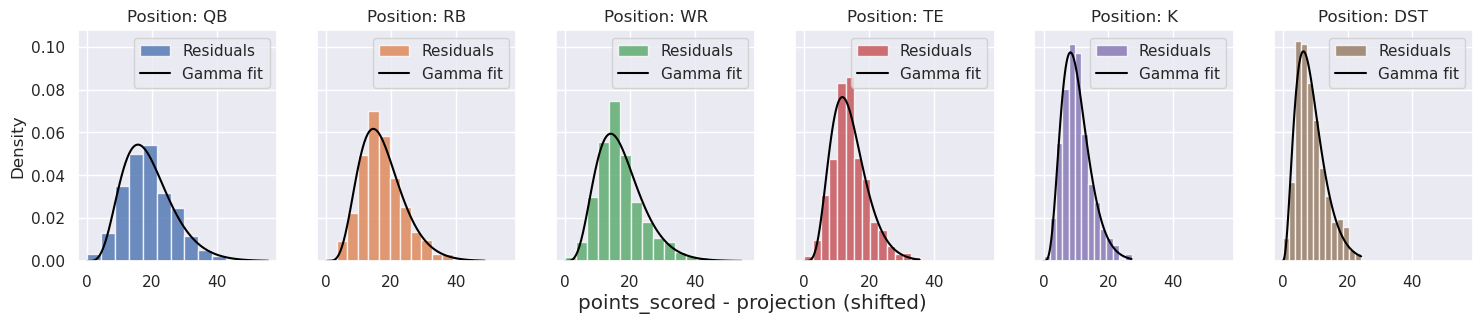

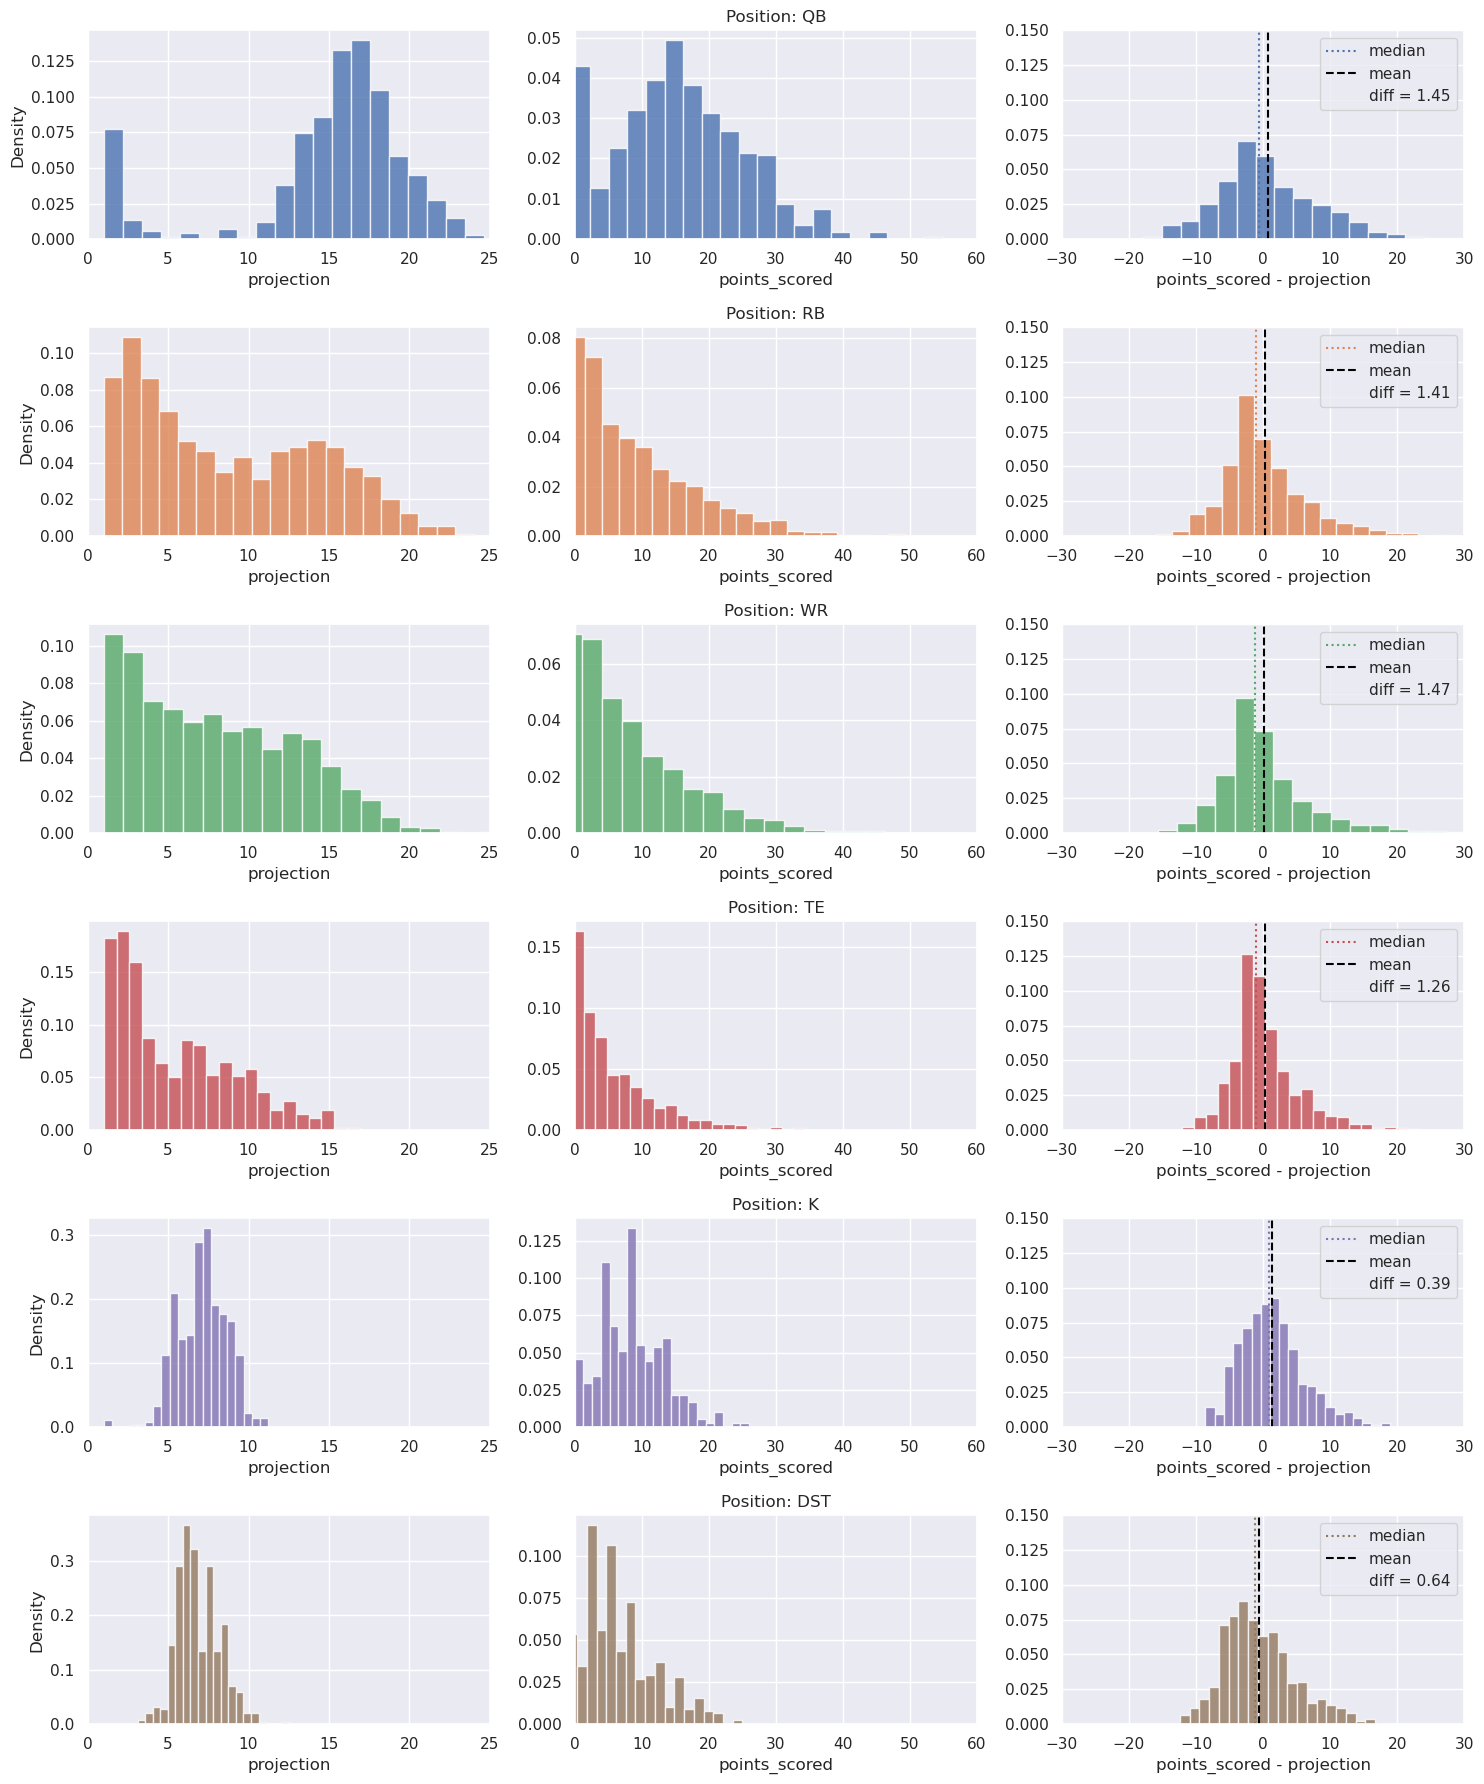

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import gamma

fig, ax = plt.subplots(1, 6, figsize=(18, 3), sharey='row', sharex='row')
for row_idx, pos in enumerate(POSITIONS):
    data_copy = data.loc[(data['projection'] > 2.0) & (data['points_scored'] > 2.0) & (data['position'] == pos)].copy()
    residuals = data_copy['points_scored'].values - data_copy['projection'].values
    residuals_min = np.min(residuals)
    residuals = residuals - residuals_min + 1e-3  # shift to be positive
    mean, var = np.mean(residuals), np.var(residuals)
    a = mean**2 / var
    scale = var / mean
    x = np.linspace(0, np.max(residuals), 100)
    plt.sca(ax[row_idx])
    plt.title(f'Position: {pos}')
    binvals, bins, _ = plt.hist(residuals, alpha=0.8, density=True, bins='doane', label='Residuals', color=position_colors[pos])
    gamma_pdf = gamma.pdf(x, a, scale=scale)
    plt.plot(x, gamma_pdf, label='Gamma fit', color='black')
    plt.legend()
    # plt.xlabel('points_scored - projection (shifted)')
    if row_idx == 0:
        plt.ylabel('Density')
plt.suptitle('points_scored - projection (shifted)', y=0.0, ha='center')
plt.savefig(FIGURE_PATH / 'residuals_gamma_fit.png', bbox_inches='tight', dpi=300)


# display(data['residual'].value_counts().sort_values())
print(
    data[data['position'] == 'QB']['residual'].mean(), data[data['position'] == 'QB']['residual'].median()
)
print(
    data[data['position'] == 'QB']['residual'].mean() - data[data['position'] == 'QB']['residual'].median()
)


fig, ax = plt.subplots(len(POSITIONS), 3, figsize=(15, 3*len(POSITIONS)), sharex='col')
bins = 20

for row_idx, pos in enumerate(POSITIONS):
    plot_data = data[data['position'] == pos].copy()

    plt.sca(ax[row_idx][0])
    plt.hist(plot_data['projection'], bins=bins, color=position_colors[pos], alpha=0.8, density=True)
    plt.xlim([0, 25])
    plt.xlabel('projection')
    plt.ylabel('Density')
    plt.gca().xaxis.set_tick_params(labelbottom=True)
    plt.sca(ax[row_idx][1])
    plt.hist(plot_data['points_scored'], bins=bins, color=position_colors[pos], alpha=0.8, density=True)
    plt.xlim([0, 60])
    plt.title(f'Position: {pos}')
    plt.xlabel('points_scored')
    plt.gca().xaxis.set_tick_params(labelbottom=True)
    plt.sca(ax[row_idx][2])
    plt.hist(plot_data['residual'], bins=bins, color=position_colors[pos], alpha=0.8, density=True)
    median = plot_data['residual'].median()
    mean = plot_data['residual'].mean()
    plt.plot([median]*2, [0, 0.2], color=position_colors[pos], linestyle=':', label='median')
    plt.plot([mean]*2, [0, 0.2], color='black', linestyle='--', label='mean')
    plt.plot([], [], ' ', label=f'diff = {mean - median:.2f}')
    plt.legend()
    plt.xlim([-30, 30])
    plt.ylim([0, 0.15])
    plt.xlabel('points_scored - projection')
    plt.gca().xaxis.set_tick_params(labelbottom=True)

    # plt.sca(ax[0])
    # plt.hist(data[data['position'] == 'QB']['residual'], bins=50, color='b')
    # plt.plot([data[data['position'] == 'QB']['residual'].median()]*2, [0, 100], 'b--')
    # plt.plot([data[data['position'] == 'QB']['residual'].mean()]*2, [0, 100], 'k--')



    # plt.sca(ax[0])
    # plt.hist(data[data['position'] == 'QB']['residual'], bins=50, color='b')
    # plt.plot([data[data['position'] == 'QB']['residual'].median()]*2, [0, 100], 'b--')
    # plt.plot([data[data['position'] == 'QB']['residual'].mean()]*2, [0, 100], 'k--')

    # plt.ylim([0, 100])

plt.tight_layout()
plt.savefig(FIGURE_PATH / 'points_distributions.png', bbox_inches='tight', dpi=300)
plt.show()

# Single-Player Mean

5094 1274
RMSE Trivial = 6.057950774182435, mean residual 0.42898744113029835
RMSE Linear = 6.026528733364095, mean residual 0.12128626354261121
RMSE Forest = 6.847579477994388, mean residual 0.08292382168531724


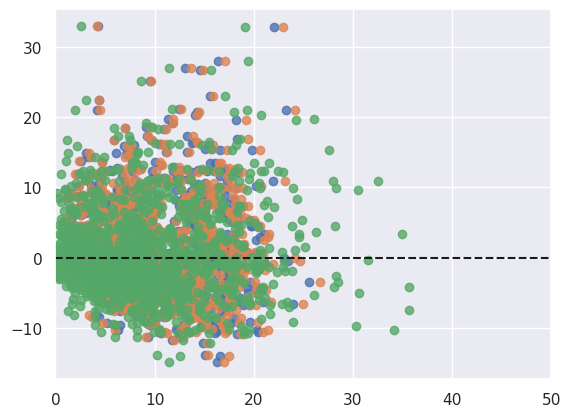

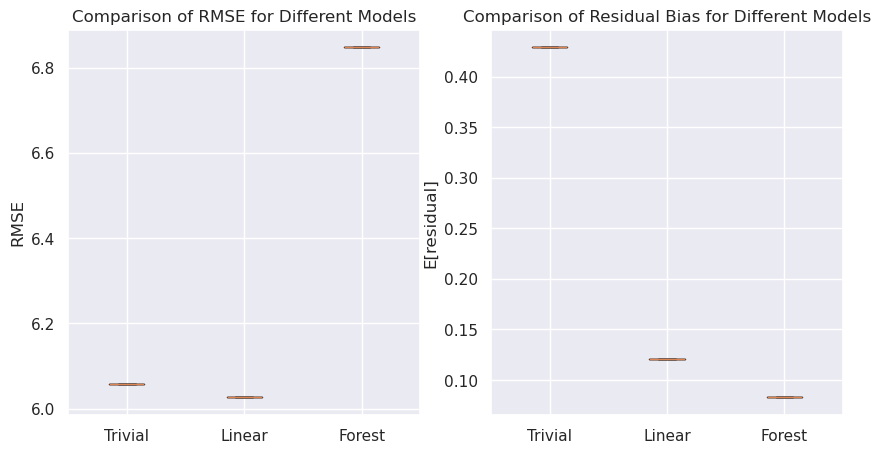

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor

data = data.reset_index(drop=True)
train_idx = data.index.isin(data.sample(frac=0.8).index)
test_idx = ~train_idx
print(sum(train_idx), sum(test_idx))

cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(categories='auto', sparse_output=False, handle_unknown='ignore')),
])
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])
lin_reg_preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, ['position', 'is_home']),
    ('num', num_pipeline, ['projection'])
])
lin_reg_pipeline = Pipeline([
    ('preprocessor', lin_reg_preprocessor),
    ('lin_reg', LinearRegression())
])
forest_pipeline = Pipeline([
    ('preprocessor', lin_reg_preprocessor),
    ('forest', RandomForestRegressor())
])
tree_pipeline = Pipeline([
    ('preprocessor', lin_reg_preprocessor),
    ('tree', DecisionTreeRegressor())
])

# Do a simulation
DO_SIMULATION = False
if DO_SIMULATION:
    nrounds = 100
else:
    nrounds = 1
test_frac = 0.2
rmse = {
    'trivial': [],
    'linear': [],
    'forest': []
}
residual_bias = {
    'trivial': [],
    'linear': [],
    'forest': []
}
for _round in range(nrounds):
    train_idx = data.index.isin(data.sample(frac=(1 - test_frac)).index)
    test_idx = ~train_idx

    lin_reg = lin_reg_pipeline.fit(data.loc[train_idx], data.loc[train_idx, 'points_scored'])
    forest = forest_pipeline.fit(data.loc[train_idx], data.loc[train_idx, 'points_scored'])
    
    rmse['trivial'].append(root_mean_squared_error(data.loc[test_idx, 'projection'], data.loc[test_idx, 'points_scored']))
    rmse['linear'].append(root_mean_squared_error(lin_reg.predict(data.loc[test_idx]), data.loc[test_idx, 'points_scored']))
    rmse['forest'].append(root_mean_squared_error(forest.predict(data.loc[test_idx]), data.loc[test_idx, 'points_scored']))
    
    residual_bias['trivial'].append(np.mean(data.loc[test_idx, 'points_scored'] - data.loc[test_idx, 'projection']))
    residual_bias['linear'].append(np.mean(data.loc[test_idx, 'points_scored'] - lin_reg.predict(data.loc[test_idx])))
    residual_bias['forest'].append(np.mean(data.loc[test_idx, 'points_scored'] - forest.predict(data.loc[test_idx])))

print(f'RMSE Trivial = {np.mean(rmse["trivial"])}, mean residual {np.mean(residual_bias["trivial"])}')
print(f'RMSE Linear = {np.mean(rmse["linear"])}, mean residual {np.mean(residual_bias["linear"])}')
print(f'RMSE Forest = {np.mean(rmse["forest"])}, mean residual {np.mean(residual_bias["forest"])}')

plt.figure()
plt.scatter(data.loc[test_idx, 'projection'], data.loc[test_idx, 'residual'], alpha=0.8)
plt.scatter(lin_reg.predict(data.loc[test_idx]), data.loc[test_idx, 'residual'], alpha=0.8)
plt.scatter(forest.predict(data.loc[test_idx]), data.loc[test_idx, 'residual'], alpha=0.8)
plt.plot([0, 50], [0, 0], 'k--')
plt.xlim([0, 50])
# plt.ylim([0, 50])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax[0])
plt.boxplot([rmse['trivial'], rmse['linear'], rmse['forest']], labels=['Trivial', 'Linear', 'Forest'])
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.sca(ax[1])
plt.boxplot([residual_bias['trivial'], residual_bias['linear'], residual_bias['forest']], labels=['Trivial', 'Linear', 'Forest'])
plt.ylabel('E[residual]')
plt.title('Comparison of Residual Bias for Different Models')
plt.savefig(FIGURE_PATH / 'mean_pts_model_performance_comparison.png')

plt.show()

  proj_bin points_scored            projection           position  bin_left  \
                    mean        var       mean       var                      
0        1      1.733846  37.046299   2.138590  3.393329       QB   1.00000   
1        2     12.889744  49.623104  12.570000  1.038065       QB   8.87500   
2        3     15.360253  49.999779  14.414557  0.169925       QB  13.70500   
3        4     16.402051  64.661700  15.687308  0.084191       QB  15.11000   
4        5     17.130649  61.534048  16.604026  0.076814       QB  16.13000   
5        6     19.676667  62.563651  17.451667  0.063695       QB  17.07000   
6        7     18.597143  67.968765  18.664935  0.277557       QB  17.87000   
7        8     22.991795  87.617615  21.135513  1.200898       QB  19.65750   
0        1      2.183735  10.639916   1.694880  0.169749       RB   1.00000   
1        2      3.566864  18.315919   2.970059  0.120987       RB   2.35125   
2        3      4.704969  30.278100   4.343975  0.24

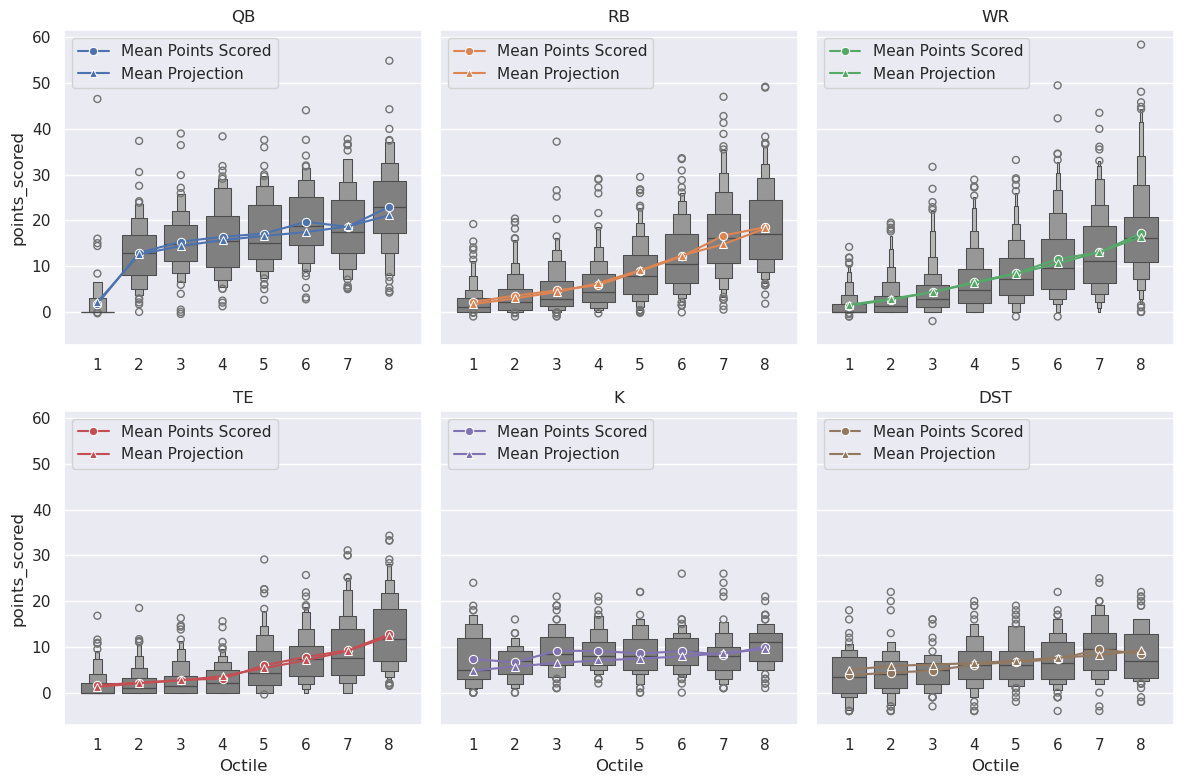

In [51]:
cuts = np.arange(0.0, 30.0, 5.0)
col_names = [f'{cuts[i]}-{cuts[i+1]}' for i in range(len(cuts)-1)]
# data['proj_bin'] = pd.cut(data['projection'], bins=cuts, labels=col_names)
qtile = 8

_, ax = plt.subplots(2, 3, figsize=(12,8), sharex='all', sharey='all')
ax_flat = [ax[0][0], ax[0][1], ax[0][2], ax[1][0], ax[1][1], ax[1][2]]
mean_vars = []
for i, pos in enumerate(POSITIONS):
    pos_data = data[data['position'] == pos].copy()
    pos_data['proj_bin'], bins = pd.qcut(pos_data['projection'], q=qtile, labels=range(1,qtile+1), retbins=True)
    pos_data['proj_bin'] = pos_data['proj_bin'].astype(int)
    # print(bins)
    mean_var = pos_data.groupby(['proj_bin'], observed=True)[['points_scored', 'projection']].agg(['mean', 'var']).reset_index()
    mean_var['position'] = pos
    mean_var['bin_left'] = bins[:-1]
    mean_var['bin_right'] = bins[1:]
    mean_vars.append(mean_var)
    # print(mean_var)

    plt.sca(ax_flat[i])
    sns.boxenplot(x='proj_bin', y='points_scored', data=pos_data, outlier_prop=0.1, color='gray')
    sns.lineplot(x=mean_var['proj_bin']-1, y=mean_var[('points_scored', 'mean')], color=position_colors[pos], marker='o', label='Mean Points Scored')
    sns.lineplot(x=mean_var['proj_bin']-1, y=mean_var[('projection', 'mean')], color=position_colors[pos], marker='^', label='Mean Projection')
    plt.legend(loc='upper left')
    # plt.xticks(rotation=45)
    plt.gca().xaxis.set_tick_params(labelbottom=True)
    plt.xlabel('Octile')
    # plt.ylim(-5, 50)
    plt.title(pos)
plt.tight_layout()
plt.savefig(FIGURE_PATH / 'points_scored_detailed_distributions.png', bbox_inches='tight', dpi=300)
mean_vars = pd.concat(mean_vars)
print(mean_vars)

# print a latex table of bin edges for copying
print('Latex table of projection bin edges:')
print(r'\begin{tabular}{ccccccccc}')
print(r'Position & Bin 1 & Bin 2 & Bin 3 & Bin 4 & Bin 5 & Bin 6 & Bin 7 & Bin 8 \\')
for pos in POSITIONS:
    pos_bins = mean_vars[mean_vars['position'] == pos]['bin_left'].values
    row_str = pos + ' & '
    row_str += ' & '.join([f'{pos_bins[i]:.2f}' for i in range(len(pos_bins))])
    row_str += r' \\'
    print(row_str)
print(r'\end{tabular}')



# use the proj_bin column as a feature
# train_data = data.loc[train_idx, :].copy()
# train_data['proj_bin'] = 'NULL'
# data['proj_bin'] = 'NULL'
# bins_dict = {}
# for i, pos in enumerate(POSITIONS):
#     train_data.loc[train_data['position'] == pos, 'proj_bin'], bins_dict[pos] = pd.qcut(train_data['projection'], q=6, labels=range(1,7), retbins=True)
#     data.loc[data['position'] == pos, 'proj_bin'] = pd.cut(data['projection'], bins=bins_dict[pos], labels=range(1,7))

# lin_reg_preprocessor = ColumnTransformer([
#     ('cat', cat_pipeline, ['position', 'is_home', 'proj_bin'])
#     # ('num', num_pipeline, ['projection'])
# ])
# lin_reg_pipeline = Pipeline([
#     ('preprocessor', lin_reg_preprocessor),
#     ('lin_reg', LinearRegression())
# ])
# forest_pipeline = Pipeline([
#     ('preprocessor', lin_reg_preprocessor),
#     ('forest', RandomForestRegressor())
# ])

# lin_reg = lin_reg_pipeline.fit(data.loc[train_idx], data.loc[train_idx, 'points_scored'])
# forest = forest_pipeline.fit(data.loc[train_idx], data.loc[train_idx, 'points_scored'])

# print(f'RMSE Trivial = {root_mean_squared_error(data.loc[~train_idx, 'projection'], data.loc[~train_idx, 'points_scored'])}')
# print(f'RMSE Linear = {root_mean_squared_error(lin_reg.predict(data.loc[~train_idx]), data.loc[~train_idx, 'points_scored'])}')
# print(f'RMSE Forest = {root_mean_squared_error(forest.predict(data.loc[~train_idx]), data.loc[~train_idx, 'points_scored'])}')

# def get_bin_proj(data_in):
#     bin_results = mean_vars.copy()
#     data_in = data_in.copy()
#     data_in = data_in.merge(bin_results, on=['position', 'proj_bin'])
#     return data_in['mean'].values, data_in['points_scored'].values

# pred, actu = get_bin_proj(data.loc[~train_idx])
# print(f'RMSE Bin Proj = {root_mean_squared_error(pred, actu)}')

# plt.figure()
# plt.scatter(data.loc[test_idx, 'projection'], data.loc[test_idx, 'points_scored'], alpha=0.8)
# plt.scatter(lin_reg.predict(data.loc[test_idx]), data.loc[test_idx, 'points_scored'], alpha=0.8)
# plt.scatter(forest.predict(data.loc[test_idx]), data.loc[test_idx, 'points_scored'], alpha=0.8)
# plt.plot([0, 50], [0, 50], 'k--')
# plt.xlim([0, 50])
# plt.ylim([0, 50])
# plt.show()

# Single-Player Variance

,mean,var,position,bin_left,bin_right,qtile,bin_mean,bin_width
0,7.311795,74.369367,QB,1.000,13.705,4,7.3525,12.705
1,15.877834,57.189306,QB,13.705,16.130,4,14.9175,2.425
2,18.411871,63.280284,QB,16.130,17.870,4,17.0000,1.740
3,20.808645,82.211226,QB,17.870,24.640,4,21.2550,6.770
0,2.881493,14.948698,RB,1.000,3.530,4,2.2650,2.530
...,...,...,...,...,...,...,...,...
15,10.750000,41.039474,DST,7.800,8.000,20,7.9000,0.200
16,8.571429,36.698413,DST,8.000,8.300,20,8.1500,0.300
17,10.480000,36.676667,DST,8.300,8.600,20,8.4500,0.300
18,8.269231,42.844615,DST,8.600,9.200,20,8.9000,0.600


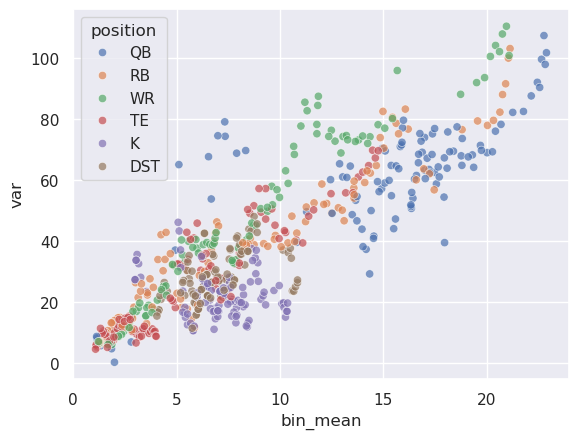

In [70]:
# Generate a dataset using the quantiles strategy as above
# We want to map the projection and position to the diagonal covariance of the actual points
# so we need a set of points (projection, points_scored)

def get_qtile_cov(data, qtile):
    mean_vars = []
    for i, pos in enumerate(POSITIONS):
        pos_data = data[data['position'] == pos].copy()
        pos_data['proj_bin'], bins = pd.qcut(pos_data['projection'], q=qtile, labels=range(1,qtile+1), retbins=True)
        # print(bins)
        mean_var = pos_data.groupby(['proj_bin'], observed=True)['points_scored'].agg(['mean', 'var']).reset_index()
        mean_var['position'] = pos
        mean_var['bin_left'] = bins[:-1]
        mean_var['bin_right'] = bins[1:]
        mean_var['qtile'] = qtile
        mean_var['bin_mean'] = (mean_var['bin_left'] + mean_var['bin_right']) / 2.0
        mean_var['bin_width'] = (mean_var['bin_right'] - mean_var['bin_left'])
        mean_vars.append(mean_var.drop(columns=['proj_bin']))
    return pd.concat(mean_vars)

qtile_data = []
for qtile in [4, 6, 8, 10, 12, 14, 16, 18, 20]:
    qtile_data.append(get_qtile_cov(data, qtile))
    
qtile_data = pd.concat(qtile_data)
display(qtile_data)

plt.figure()
sns.scatterplot(x=qtile_data['bin_mean'], y=qtile_data['var'], hue=qtile_data['position'], alpha=0.7)
plt.savefig(FIGURE_PATH / 'proj_bin_variance.png')

Loading saved mean model...
MAE Linear = 36.155076474161234
MAE Forest = 35.73673859570199
MAE Tree = 38.39299766131764


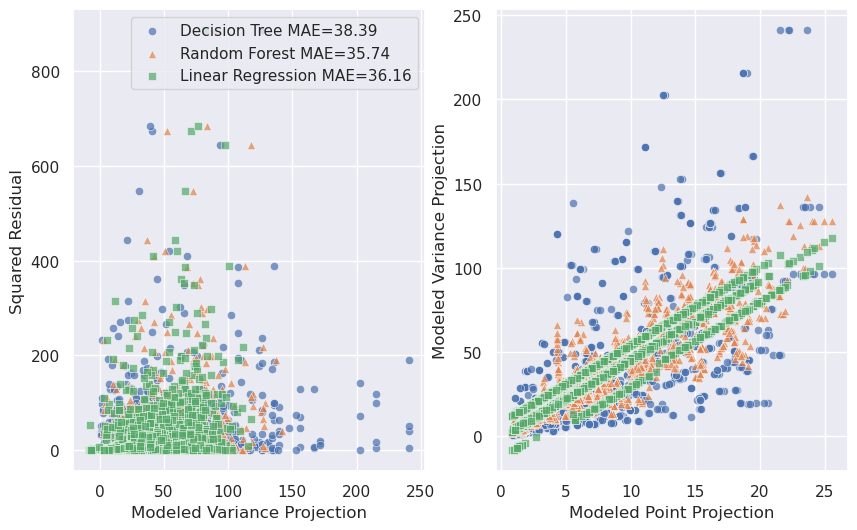

In [84]:
# use the same bins from above

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from models import save_model, load_model

SAVE_MEAN_MODEL = True
MEAN_MODEL = MODEL_PATH / 'projection_model.pkl'

lin_reg_var_pipeline = Pipeline([
    ('preprocessor', lin_reg_preprocessor),
    ('lin_reg', LinearRegression())
])
forest_var_pipeline = Pipeline([
    ('preprocessor', lin_reg_preprocessor),
    ('forest', RandomForestRegressor(
        n_estimators=100,
        min_samples_leaf=20,
        min_samples_split=50
    ))
])
tree_var_pipeline = Pipeline([
    ('preprocessor', lin_reg_preprocessor),
    ('tree', DecisionTreeRegressor(
        min_samples_leaf=10,
        min_samples_split=20
    ))
])

test_frac = 0.2
train_idx = data.index.isin(data.sample(frac=(1 - test_frac), random_state=42).index)
test_idx = ~train_idx

if MEAN_MODEL.exists():
    print('Loading saved mean model...')
    proj_model = load_model(MEAN_MODEL)
else:
    proj_model = lin_reg_pipeline.fit(data.loc[train_idx], data.loc[train_idx, 'points_scored'])

if SAVE_MEAN_MODEL:
    save_model(proj_model, MEAN_MODEL)

data_modeled = data.copy()
data_modeled['projection'] = proj_model.predict(data_modeled)
data_modeled['residual'] = data_modeled['points_scored'] - data_modeled['projection']
data_modeled['res_sq'] = data_modeled['residual'] ** 2


lin_reg = lin_reg_var_pipeline.fit(data_modeled.loc[train_idx], data_modeled.loc[train_idx, 'res_sq'])
forest = forest_var_pipeline.fit(data_modeled.loc[train_idx], data_modeled.loc[train_idx, 'res_sq'])
tree = tree_var_pipeline.fit(data_modeled.loc[train_idx], data_modeled.loc[train_idx, 'res_sq'])
# print(f'RMSE Trivial = {root_mean_squared_error(data.loc[~train_idx, 'projection'], data.loc[~train_idx, 'res_sq'])}')
print(f'MAE Linear = {mean_absolute_error(lin_reg.predict(data_modeled.loc[test_idx]), data_modeled.loc[test_idx, 'res_sq'])}')
print(f'MAE Forest = {mean_absolute_error(forest.predict(data_modeled.loc[test_idx]), data_modeled.loc[test_idx, 'res_sq'])}')
print(f'MAE Tree = {mean_absolute_error(tree.predict(data_modeled.loc[test_idx]), data_modeled.loc[test_idx, 'res_sq'])}')
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# plt.scatter(data.loc[test_idx, 'projection'], data.loc[test_idx, 'points_scored'], alpha=0.8)
plt.sca(ax[0])
sns.scatterplot(x=tree.predict(data_modeled.loc[test_idx]), y=data_modeled.loc[test_idx, 'res_sq'], alpha=0.7, marker='o', label=f'Decision Tree MAE={mean_absolute_error(tree.predict(data_modeled.loc[test_idx]), data_modeled.loc[test_idx, "res_sq"]):.2f}')
sns.scatterplot(x=forest.predict(data_modeled.loc[test_idx]), y=data_modeled.loc[test_idx, 'res_sq'], alpha=0.7, marker='^', label=f'Random Forest MAE={mean_absolute_error(forest.predict(data_modeled.loc[test_idx]), data_modeled.loc[test_idx, "res_sq"]):.2f}')
sns.scatterplot(x=lin_reg.predict(data_modeled.loc[test_idx]), y=data_modeled.loc[test_idx, 'res_sq'], alpha=0.7, marker='s', label=f'Linear Regression MAE={mean_absolute_error(lin_reg.predict(data_modeled.loc[test_idx]), data_modeled.loc[test_idx, "res_sq"]):.2f}')
plt.xlabel('Modeled Variance Projection')
plt.ylabel('Squared Residual')

plt.sca(ax[1])
sns.scatterplot(x=data_modeled.loc[test_idx, 'projection'], y=tree.predict(data_modeled.loc[test_idx]), marker='o', alpha=0.7)
sns.scatterplot(x=data_modeled.loc[test_idx, 'projection'], y=forest.predict(data_modeled.loc[test_idx]), marker='^', alpha=0.7)
sns.scatterplot(x=data_modeled.loc[test_idx, 'projection'], y=lin_reg.predict(data_modeled.loc[test_idx]), marker='s', alpha=0.7)
plt.xlabel('Modeled Point Projection')
plt.ylabel('Modeled Variance Projection')
plt.savefig(FIGURE_PATH / 'proj_var_model_comparison.png')
plt.show()

# Two-Player Covariance

,same_team,stack_type,res_product,proj_sum
1,False,QB-QB,-124.691733,35.086942
2,False,QB-RB,-66.225697,36.795760
3,True,QB-RB,64.985668,34.337620
4,False,QB-WR,-86.815140,35.550668
5,False,QB-WR,-73.595264,34.295479
...,...,...,...,...
149864,False,RB-TE,-7.070816,3.756703
149866,True,RB-DST,2.692541,8.920635
149867,False,RB-DST,-2.108245,9.791936
149891,False,DST-DST,-9.251140,15.745914


Error in qcut for label=(True, 'K-K'), qtile=4: Bin edges must be unique: Index([6.200315212441032, 6.200315212441032, 7.370406708697773,
       8.540498204954515, 8.540498204954515],
      dtype='float64', name='proj_sum').
You can drop duplicate edges by setting the 'duplicates' kwarg
Error in qcut for label=(True, 'K-K'), qtile=6: Bin edges must be unique: Index([6.200315212441032, 6.200315212441032, 6.200315212441032,
       7.370406708697773, 8.540498204954513, 8.540498204954515,
       8.540498204954515],
      dtype='float64', name='proj_sum').
You can drop duplicate edges by setting the 'duplicates' kwarg
Error in qcut for label=(True, 'K-K'), qtile=8: Bin edges must be unique: Index([6.200315212441032, 6.200315212441032, 6.200315212441032,
       6.492838086505217, 7.370406708697773,  8.24797533089033,
       8.540498204954515, 8.540498204954515, 8.540498204954515],
      dtype='float64', name='proj_sum').
You can drop duplicate edges by setting the 'duplicates' kwarg
Error in

,res_product,position,stack_group,bin_left,bin_right,qtile,bin_mean,bin_width
0,-2.419959,DST,"(False, 'DST-DST')",8.087133,11.597407,4,9.842270,3.510274
1,-4.044883,DST,"(False, 'DST-DST')",11.597407,12.873871,4,12.235639,1.276463
2,-5.038873,DST,"(False, 'DST-DST')",12.873871,13.831218,4,13.352545,0.957348
3,-8.378204,DST,"(False, 'DST-DST')",13.831218,19.043444,4,16.437331,5.212226
0,-5.947378,K,"(False, 'K-DST')",7.031559,14.134546,4,10.583053,7.102987
...,...,...,...,...,...,...,...,...
15,-4.265881,WR,"(True, 'WR-WR')",20.697782,21.897888,20,21.297835,1.200106
16,-0.938377,WR,"(True, 'WR-WR')",21.897888,23.208161,20,22.553024,1.310272
17,-5.319241,WR,"(True, 'WR-WR')",23.208161,24.803740,20,24.005950,1.595579
18,4.392847,WR,"(True, 'WR-WR')",24.803740,27.855382,20,26.329561,3.051642


,same_team,stack_type,res_product,proj_sum
28,True,QB-WR,13.954530,23.960621
5,False,QB-QB,11.109871,30.933528
21,True,K-DST,6.058693,15.066168
27,True,QB-TE,6.004317,21.015986
8,False,QB-WR,4.124102,23.989194
20,False,WR-WR,2.090511,16.601132
26,True,QB-RB,1.932200,24.922827
38,True,WR-K,1.859098,16.908289
7,False,QB-TE,1.799832,21.249347
29,True,RB-DST,1.735332,15.641980


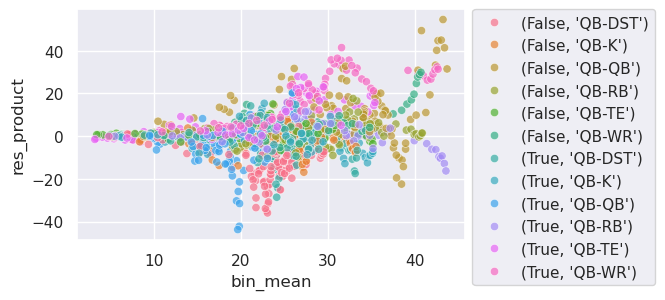

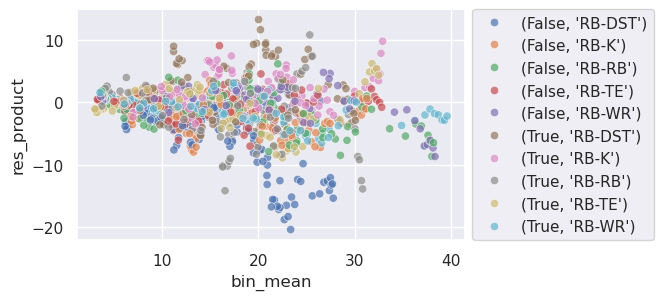

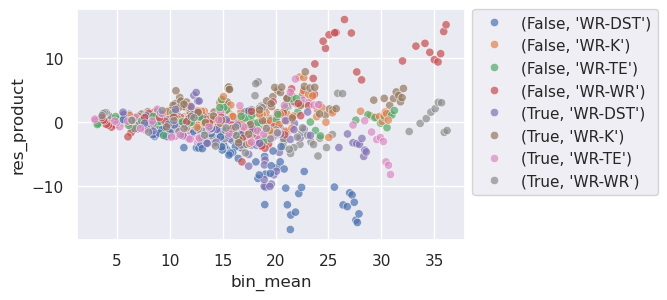

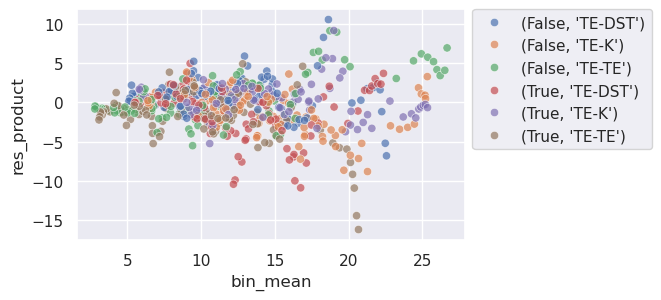

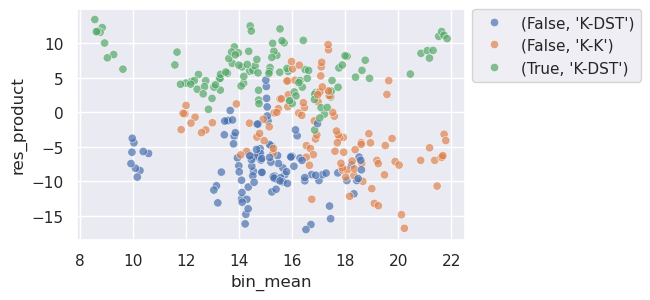

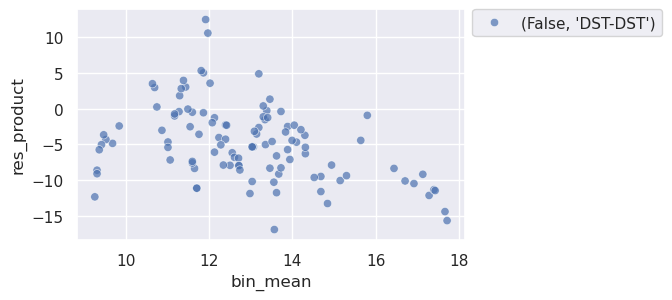

In [92]:
def compute_cov_dataset(games_data):
    # assumes 'cross_key' column is unique to each desired grouping
    product = pd.merge(games_data, games_data, how='outer', on='cross_key', suffixes=('_x', '_y'))
    product['res_product'] = product['residual_x'] * product['residual_y']
    product['proj_sum'] = product['projection_x'] + product['projection_y']

    # remove self-correlation rows
    product = product[product['player_name_x'] != product['player_name_y']]
    product['same_team'] = product['team_x'] == product['team_y']
    product['stack_type'] = product['position_x'] + '-' + product['position_y']
    product['rev_stack_type'] = product['position_y'] + '-' + product['position_x']
    product_cols = ['same_team', 'stack_type', 'res_product', 'proj_sum']
    return product[product_cols]

columns = ['cross_key', 'player_name', 'position', 'team', 'residual', 'projection']
data_modeled['cross_key'] = data_modeled['season'].astype(str) + '_' + data_modeled['week'].astype(str) + '_' + data_modeled['home_team']
cov_data = compute_cov_dataset(data_modeled[columns])
cov_data = cov_data[cov_data['stack_type'].isin(stack_types)]
display(cov_data)

# Generate a dataset using the quantiles strategy as above
# We want to map the projection and position to the diagonal covariance of the actual points
# so we need a set of points (projection, points_scored)

def get_qtile_cross_cov(data_modeled, qtile):
    mean_vars = []
    for label, grp in data_modeled.groupby(['same_team', 'stack_type']):
        try:
            grp['proj_bin'], bins = pd.qcut(grp['proj_sum'], q=qtile, retbins=True)
        except Exception as e:
            print(f"Error in qcut for label={label}, qtile={qtile}: {e}")
            continue
        # print(bins)
        # print(grp)
        mean_var = grp.groupby(['proj_bin'], observed=True)['res_product'].mean().reset_index()
        # print(mean_var)
        # print(label)
        mean_var['position'] = label[1].split('-')[0]
        mean_var['stack_group'] = str(label)
        mean_var['bin_left'] = bins[:-1]
        mean_var['bin_right'] = bins[1:]
        mean_var['qtile'] = qtile
        mean_var['bin_mean'] = (mean_var['bin_left'] + mean_var['bin_right']) / 2.0
        mean_var['bin_width'] = (mean_var['bin_right'] - mean_var['bin_left'])
        mean_vars.append(mean_var.drop(columns=['proj_bin']))
    return pd.concat(mean_vars)

qtile_data = []
for qtile in [4, 6, 8, 10,12, 14, 16, 18, 20]:
    qtile_data.append(get_qtile_cross_cov(cov_data, qtile))
    
qtile_data = pd.concat(qtile_data)
display(qtile_data)

for pos in POSITIONS:
    plot_data = qtile_data[qtile_data['position'] == pos]
    plt.figure(figsize=(5, 3))
    sns.scatterplot(x=plot_data['bin_mean'], y=plot_data['res_product'], hue=plot_data['stack_group'], alpha=0.7)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) 
    plt.savefig(FIGURE_PATH / f'proj_bin_cross_cov_{pos}.png')

grouped = cov_data.groupby(['same_team', 'stack_type']).agg({'res_product': 'mean', 'proj_sum': 'mean'}).reset_index()
display(grouped.sort_values(['res_product'], ascending=False))

/home/matthew/miniconda3/envs/dfs/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


MAE DF Model = 21.209052093007493
MAE Linear = 21.170640102955012
MAE Forest = 21.635599248829617


/home/matthew/miniconda3/envs/dfs/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/matthew/miniconda3/envs/dfs/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/matthew/miniconda3/envs/dfs/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


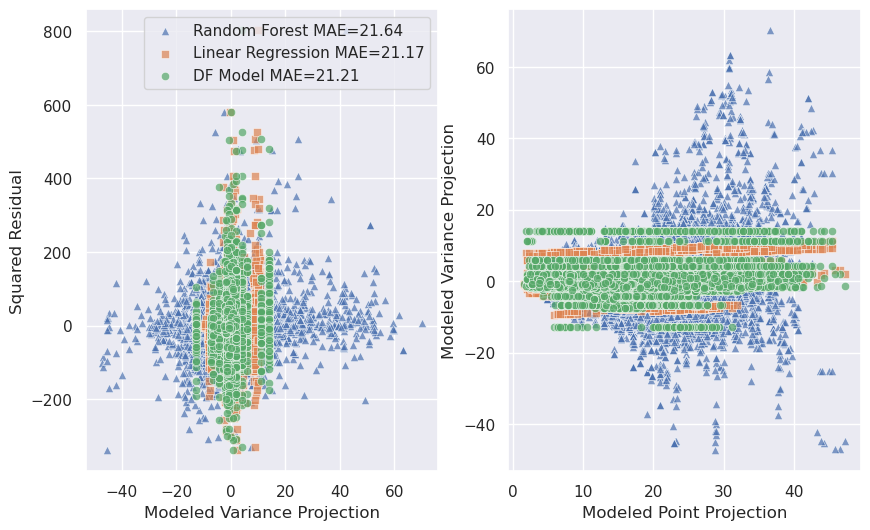

In [94]:
# Create models
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from models import DataFrameLookupModel, save_model, load_model

SAVE_MODELS = False

cov_data = cov_data.reset_index(drop=True)
train_idx = cov_data.sample(frac=0.8, random_state=42).index
test_idx = cov_data.index.difference(train_idx)

cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(categories='auto', sparse_output=False, handle_unknown='ignore')),
])
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])
lin_reg_preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, ['same_team', 'stack_type']),
    ('num', num_pipeline, ['proj_sum'])
])
lin_reg_pipeline = Pipeline([
    ('preprocessor', lin_reg_preprocessor),
    ('lin_reg', LinearRegression())
])
forest_pipeline = Pipeline([
    ('preprocessor', lin_reg_preprocessor),
    ('forest', RandomForestRegressor(n_estimators=100, random_state=42,
        min_samples_leaf=20,
        min_samples_split=50))
])

lin_reg_pipeline.fit(cov_data.loc[train_idx], cov_data.loc[train_idx, 'res_product'])
forest_pipeline.fit(cov_data.loc[train_idx], cov_data.loc[train_idx, 'res_product'])

df_model_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
            transformers=[('passthrough_dummy_name', 'passthrough', ['same_team', 'stack_type'])],
            remainder='drop'
        )
    ),
    ('df_model', DataFrameLookupModel(grouped, feature_cols=['same_team', 'stack_type'], target_col='res_product'))
])

df_model_pipeline.fit(grouped, grouped[['res_product']])

print(f'MAE DF Model = {mean_absolute_error(df_model_pipeline.predict(cov_data.loc[test_idx]), cov_data.loc[test_idx, "res_product"])}')
print(f'MAE Linear = {mean_absolute_error(lin_reg_pipeline.predict(cov_data.loc[test_idx]), cov_data.loc[test_idx, "res_product"])}')
print(f'MAE Forest = {mean_absolute_error(forest_pipeline.predict(cov_data.loc[test_idx]), cov_data.loc[test_idx, "res_product"])}')

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# plt.scatter(data.loc[test_idx, 'projection'], data.loc[test_idx, 'points_scored'], alpha=0.8)
plt.sca(ax[0])
sns.scatterplot(x=forest_pipeline.predict(cov_data.loc[test_idx]), y=cov_data.loc[test_idx, 'res_product'], alpha=0.7, marker='^', label=f'Random Forest MAE={mean_absolute_error(forest_pipeline.predict(cov_data.loc[test_idx]), cov_data.loc[test_idx, "res_product"]):.2f}')
sns.scatterplot(x=lin_reg_pipeline.predict(cov_data.loc[test_idx]), y=cov_data.loc[test_idx, 'res_product'], alpha=0.7, marker='s', label=f'Linear Regression MAE={mean_absolute_error(lin_reg_pipeline.predict(cov_data.loc[test_idx]), cov_data.loc[test_idx, "res_product"]):.2f}')
sns.scatterplot(x=df_model_pipeline.predict(cov_data.loc[test_idx]), y=cov_data.loc[test_idx, 'res_product'], alpha=0.7, marker='o', label=f'DF Model MAE={mean_absolute_error(df_model_pipeline.predict(cov_data.loc[test_idx]), cov_data.loc[test_idx, "res_product"]):.2f}')

plt.xlabel('Modeled Variance Projection')
plt.ylabel('Squared Residual')

plt.sca(ax[1])
sns.scatterplot(x=cov_data.loc[test_idx, 'proj_sum'], y=forest_pipeline.predict(cov_data.loc[test_idx]), marker='^', alpha=0.7)
sns.scatterplot(x=cov_data.loc[test_idx, 'proj_sum'], y=lin_reg_pipeline.predict(cov_data.loc[test_idx]), marker='s', alpha=0.7)
sns.scatterplot(x=cov_data.loc[test_idx, 'proj_sum'], y=df_model_pipeline.predict(cov_data.loc[test_idx]), marker='o', alpha=0.7)
plt.xlabel('Modeled Point Projection')
plt.ylabel('Modeled Variance Projection')
plt.savefig(FIGURE_PATH / 'proj_cov_model_comparison.png')
plt.show()



RMSE for test set using Linear Regression: 59.11991456848317
RMSE for test set using DataFrame Lookup: 59.01371069358413


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


RMSE for test set using Random Forest: 55.541266624473366


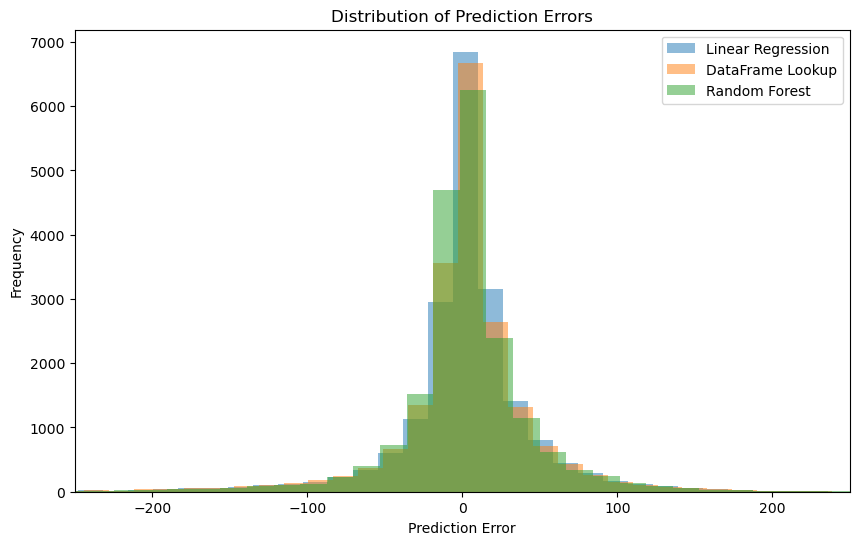

In [ ]:
# Evaluate models on the full dataset
models = {
    'Linear Regression': lin_reg_pipeline,
    'DataFrame Lookup': df_model_pipeline,
    'Random Forest': forest_pipeline
}
distributions = {}
for name, model in models.items():
    predictions = model.predict(cov_data.loc[test_idx])
    distributions[name] = predictions - cov_data.loc[test_idx, "res_product"].values
    print(f'RMSE for test set using {name}: {root_mean_squared_error(cov_data.loc[test_idx, "res_product"], predictions)}')

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for name, distribution in distributions.items():
    plt.hist(distribution, bins=100, alpha=0.5, label=name)
plt.xlim(-250, 250)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.show()

In [ ]:
# Inspect the predictions on average

results = pd.DataFrame(index=grouped[['stack_type', 'same_team']].copy())
results['df_model'] = df_model_pipeline.predict(grouped)
results['lin_reg'] = lin_reg_pipeline.predict(grouped)
results['forest'] = forest_pipeline.predict(grouped)
display(results)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


,df_model,lin_reg,forest
"(K-K, False)",-2.659371,-2.000000,2.035661
"(QB-K, False)",-2.485887,-1.738281,-0.778280
"(QB-QB, False)",10.870024,7.052734,6.439500
"(QB-RB, False)",3.018365,3.759766,5.031710
"(QB-TE, False)",5.826062,9.537109,9.680270
"(QB-WR, False)",9.434752,17.660156,3.457620
"(RB-K, False)",-2.401383,-0.093750,5.353422
"(RB-RB, False)",-0.297556,-0.619141,-8.540976
"(RB-TE, False)",3.141947,1.839844,11.151407
"(RB-WR, False)",2.425646,1.076172,-11.037753
